In [27]:
import sys
sys.path.append("/Users/nikita/Desktop/Test Assigment tabby")


from src.dataloader import DataLoader
from src.estimator import ModelEvaluator

import numpy as np
import lightgbm as lgb
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import optuna


import warnings

warnings.filterwarnings("ignore")


In [2]:
with open('/Users/nikita/Desktop/Test Assigment tabby/data/best_cols.pkl', 'rb') as f:
    best_features = pickle.load(f)

In [3]:
dl = DataLoader(path_to_data="/Users/nikita/Desktop/Test Assigment tabby/data/clear_dataset.csv",
                time_column='sample_date',
                threshold_cat_feature=5,
                drop_disbalance=None)

In [13]:
X_train, X_test, y_train, y_test = dl.run()
total_samples = len(y_train)  
class_weight_0 = total_samples / (2 * np.bincount(y_train)[0])
class_weight_1 = total_samples / (2 * np.bincount(y_train)[1])

class_weights = {0: class_weight_0, 1: class_weight_1}

### Logistic Regression

Metrics:   train test
ROC_AUC:   0.743 0.74
Gini:      0.485 0.479
F1_score:  0.288 0.291
Log_loss:  11.136 11.621


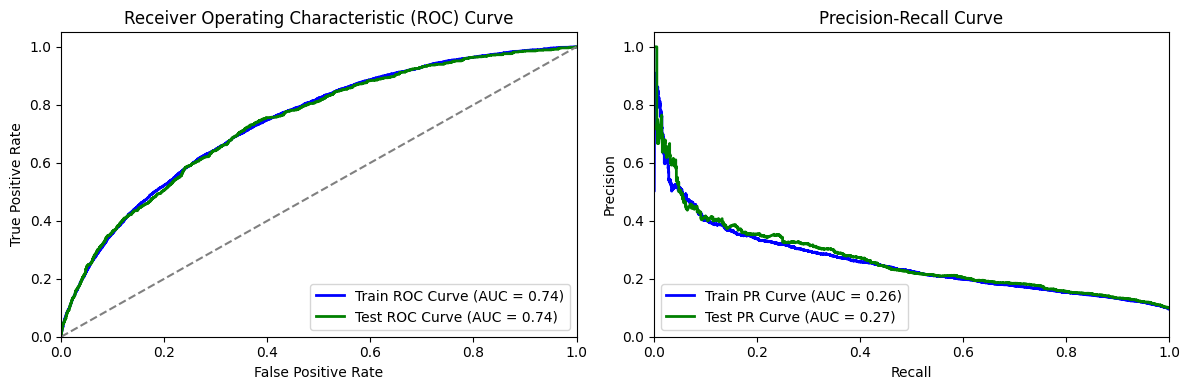

In [14]:
model = LogisticRegression(class_weight=class_weights)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[best_features])
X_test_scaled = scaler.transform(X_test[best_features])
evaluator = ModelEvaluator(model)
evaluator.run(X_train_scaled, X_test_scaled, y_train, y_test)

### KNN

Metrics:   train test
ROC_AUC:   0.906 0.638
Gini:      0.812 0.276
F1_score:  0.256 0.135
Log_loss:  3.143 3.777


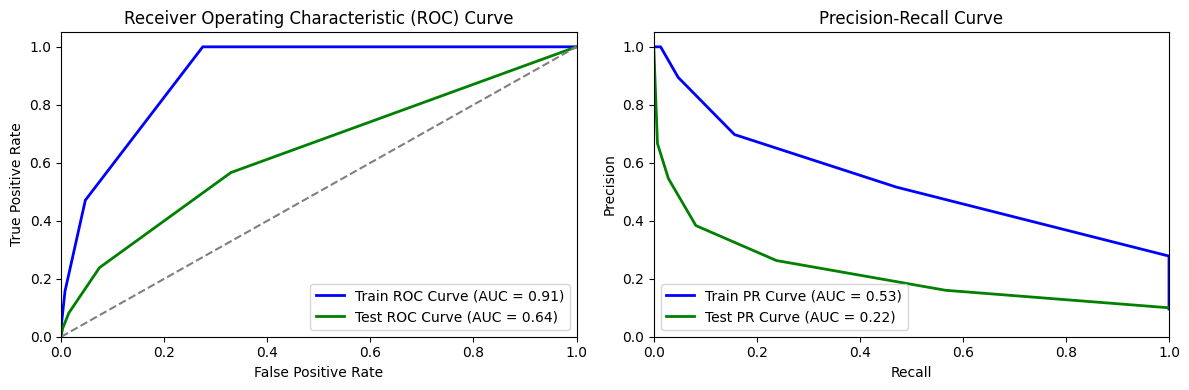

In [17]:
model = KNeighborsClassifier(n_neighbors=5)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[best_features])
X_test_scaled = scaler.transform(X_test[best_features])
evaluator = ModelEvaluator(model)
evaluator.run(X_train_scaled, X_test_scaled, y_train, y_test)

### LightGBM

Metrics:   train test
ROC_AUC:   0.935 0.78
Gini:      0.87 0.561
F1_score:  0.505 0.352
Log_loss:  6.094 8.334


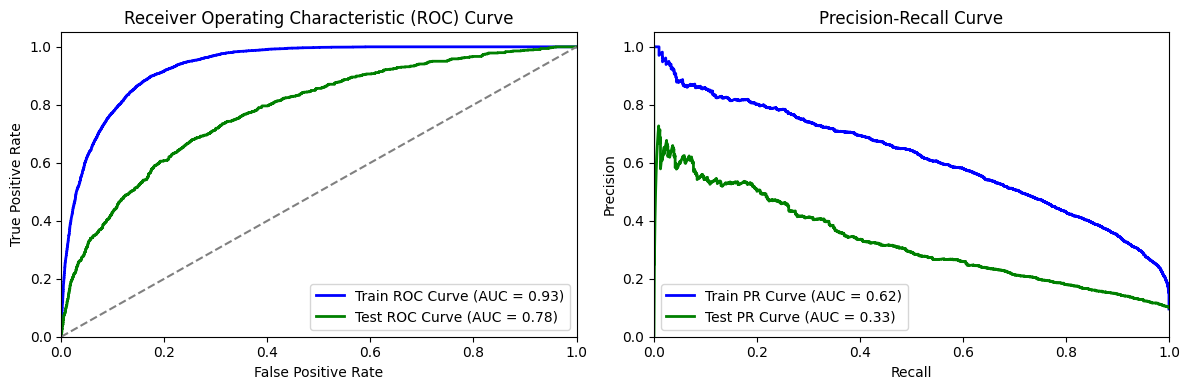

In [18]:
model = lgb.LGBMClassifier(verbose=-1, class_weight=class_weights)
evaluator = ModelEvaluator(model)
evaluator.run(X_train[best_features], X_test[best_features], y_train, y_test)

### Optimize lightGBM using optuna

In [24]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold


In [28]:
X_train_, X_valid, y_train_, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [36]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'verbose': -1,
        'n_jobs': -1,
        'random_state': 42,
    }

    dtrain = lgb.Dataset(X_train_, label=y_train_)

    model = lgb.train(params, dtrain)

    y_pred = model.predict(X_valid)

    roc_auc = -roc_auc_score(y_valid, y_pred)

    return roc_auc


In [41]:
study = optuna.create_study(direction='minimize')  # Since we want to minimize the negative ROC AUC
study.optimize(objective, n_trials=100)  # You can adjust the number of trials as needed

# Print the best trial parameters and value (negative ROC AUC)
print("Best trial:")
best_trial = study.best_trial
print("  Value: {:.4f}".format(-best_trial.value))
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-10-09 22:44:42,033] A new study created in memory with name: no-name-0746d983-cde8-4d16-a939-db1374023e88
[I 2023-10-09 22:44:43,217] Trial 0 finished with value: -0.7490298680558977 and parameters: {'num_leaves': 65, 'learning_rate': 0.0012066890807652356, 'feature_fraction': 0.36606745833451015, 'bagging_fraction': 0.8185880837073599, 'bagging_freq': 2, 'max_depth': 11, 'min_child_samples': 13}. Best is trial 0 with value: -0.7490298680558977.
[I 2023-10-09 22:44:44,354] Trial 1 finished with value: -0.7429401797297075 and parameters: {'num_leaves': 73, 'learning_rate': 0.00016960311010663496, 'feature_fraction': 0.2760305025340162, 'bagging_fraction': 0.7898889897119346, 'bagging_freq': 10, 'max_depth': 17, 'min_child_samples': 10}. Best is trial 0 with value: -0.7490298680558977.
[I 2023-10-09 22:44:44,764] Trial 2 finished with value: -0.7281489389871422 and parameters: {'num_leaves': 14, 'learning_rate': 0.0027428275127733704, 'feature_fraction': 0.34787467078011114, 'bag

Best trial:
  Value: 0.7889
  Params: 
    num_leaves: 93
    learning_rate: 0.0567411581353529
    feature_fraction: 0.5093894964503696
    bagging_fraction: 0.9761155911592959
    bagging_freq: 3
    max_depth: 16
    min_child_samples: 18


Metrics:   train test
ROC_AUC:   0.98 0.785
Gini:      0.959 0.57
F1_score:  0.641 0.371
Log_loss:  3.773 6.659


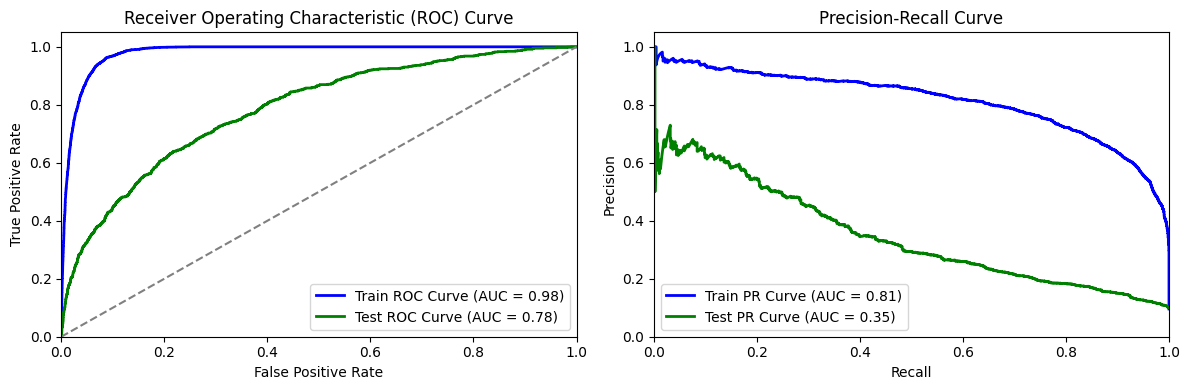

In [42]:
params = best_trial.params
model = lgb.LGBMClassifier(verbose=-1, class_weight=class_weights, **params)
evaluator = ModelEvaluator(model)
evaluator.run(X_train[best_features], X_test[best_features], y_train, y_test)